In [59]:
#import matplotlib.pyplot as plt
import pandas as pd 

df = pd.read_csv('./data/covid19_disinfo_data/English/covid19_infodemic_english_data.tsv', sep='\t')
df = df.drop(['q2_label', 'q3_label', 'q4_label', 'q5_label', 'q6_label', 'q7_label'], axis=1)
df = df.rename(columns={'q1_label': 'Has_Verifiable_Claim'})
df

,tweet_id,text,Has_Verifiable_Claim
0,1241025578527903750,For the average American the best way to tell ...,no
1,1240467080954228737,this is fucking bullshit,no
2,1240716889162018816,Can y’all please just follow the government’s ...,no
3,1241062514886090754,No offense but the corona virus disappearing b...,no
4,1241447017945223169,This is the face of someone who just spent 9 h...,yes
...,...,...,...
499,1235967176475111432,President Trump's comments about the coronavir...,yes
500,1236056191324864515,Drug companies reportedly killed a provision i...,yes
501,1235987075440283648,Does @twitter have a team fighting covid-19 ru...,no
502,1235959558058754048,#FOX to cause PANDEMIC #FoxNews is spreading ...,yes


In [202]:
#translate to Indic languages
from googletrans import Translator
translator = Translator()

#df_bangla = df.copy()
#df_bangla['text'] = df_bangla['text'].apply(lambda text : translator.translate(text, dest='bn').text)

df_hindi = df.copy()
df_hindi['text'] = df_hindi['text'].apply(lambda text : translator.translate(text, dest='hi').text)


In [205]:
#drop rows with english text
#idx_drop_bn = [index for index, row in df_bangla.iterrows() if translator.detect(row['text']).lang == 'en']
idx_drop_hi = [index for index, row in df_hindi.iterrows() if translator.detect(row['text']).lang == 'en']

In [206]:
df_hindi_mod = df_hindi.copy()
df_hindi_mod = df_hindi_mod.drop(idx_drop_hi)
print(len(df_hindi_mod))

349


In [175]:
df_bangla_mod = df_bangla.copy()
df_bangla_mod = df_bangla_mod.drop(idx_drop_bn)
print(len(df_bangla_mod))

380


In [176]:
df_bangla_mod

,tweet_id,text,Has_Verifiable_Claim
0,1241025578527903750,গড় আমেরিকানদের কাছে আপনার কোভিড -১৯ আছে কিনা ...,no
1,1240467080954228737,এই বকশি বাজানো হয়,no
2,1240716889162018816,আপনি কি দয়া করে কেবলমাত্র সরকারের নির্দেশাবলী...,no
3,1241062514886090754,কোনও অপরাধ নয় তবে এপ্রিলের আগে সফল হওয়ার আগে...,no
4,1241447017945223169,লন্ডনের আশেপাশের গুরুতর অসুস্থ কোভিড ১৯ রোগীদে...,yes
...,...,...,...
423,1237585675571974145,"যদি এই টুইটটিতে 10 কেটি আরটি হয়, আমি লিন উপত্...",no
426,1237412870192640005,আমাদের কীভাবে সম্ভাব্য COVID-19 ক্ষেত্রে যোগায...,no
427,1237219650456489984,মিডিয়া কর্নাভাইরাস পেয়ে কনজারভেটিভদের উদযাপন...,yes
429,1237137755651616770,যদি করোনা এখানে কেবলমাত্র লোকেরা পাচ্ছে তবে .....,no


In [227]:
def preprocess(df_lang):
    
    import re
    tweets = {}
    tweets['text_info'] = {}

    #extract text
    tweets['text'] = df_lang['text']
    
    #extract labels
    tweets['labels'] = df_lang['Has_Verifiable_Claim'].apply(lambda label : 1 if label == 'yes' else 0)
    
    #text features
    tweets['text_info']['len'] =  tweets['text'].apply(lambda x: len(x))
    tweets['text_info']['num_of_upper_char'] = tweets['text'].apply(lambda text: sum([len([char for char in word if char.isupper()]) for word in text]))
    tweets['text_info']['has_qmarks'] = tweets['text'].apply(lambda text: True if '?' in text else False) 
    tweets['text_info']['num_of_qmarks'] = tweets['text'].apply(lambda text: sum([len([char for char in word if char == '?']) for word in text])) 
    tweets['text_info']['has_exclmmarks'] = tweets['text'].apply(lambda text: True if '!' in text else False)
    tweets['text_info']['num_of_exclmmarks'] = tweets['text'].apply(lambda text: sum([len([char for char in word if char == '!']) for word in text]))
                                                
    #lowercase all words
    tweets['text'] = tweets['text'].apply(lambda x: x.lower())

    #remove urls
    url = r'http\S+'
    tweets['text'] = tweets['text'].apply(lambda x: re.sub(url, 'URL', x, flags=re.MULTILINE))

    #remove emojis
    emoji = re.compile("["         u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
    tweets['text'] = tweets['text'].apply(lambda x: emoji.sub(r'', x))
    
    
    #uncomment for english
    '''from ekphrasis.classes.segmenter import Segmenter
    #segmenter using the word statistics from Twitter
    #if not working..go to /anaconda3/envs/covidfake/lib/python3.6/site-packages/ekphrasis/examples..run demo_segmenter to create reqd files
    #that will create stats file in your home directory : /home/debanjana_ibm/.ekphrasis/
    seg_tw = Segmenter(corpus='twitter')
    tweets['text'] = tweets['text'].apply(lambda x:[seg_tw.segment(word) for word in x])
    tweets['text'] = tweets['text'].apply(lambda x:[word[1:] if word[0] == '#' else word for word in x])'''
    tweets['text'] = tweets['text'].apply(lambda x:[word[1:] if word[0] == '#' else word for word in x.split()])
    
    #rejoin to form a sentence
    tweets['text'] = tweets['text'].apply(lambda x: ' '.join(x))
    
    
    return tweets

In [132]:
#preprocessing English tweets
tweets = preprocess(df)
#length of tweets
print(len(tweets['text']))
print('-------------------------------------------')
#original text
print('Original message : ', df.iloc[502]['text'] )
print('-------------------------------------------')
#preprocessed text
print('Preprocessed message : ', tweets['text'][502])
print('-------------------------------------------')
#preprocessed text
print('Message has verifiable claim : ', tweets['labels'][502])

Reading twitter - 1grams ...
Reading twitter - 2grams ...
504
-------------------------------------------
Original message :  #FOX to cause PANDEMIC  #FoxNews is spreading #Trump's #CORONAVIRUS LIES faster than the disease itself  Steer clear of MAGA hats: They're being told the whole thing is a HOAX, and their leader's got it under control, go to work  #MOG☘️ #Christians #MAGA https://t.co/RmrDtoL4bE
-------------------------------------------
Preprocessed message :  fox to cause pandemic  fox news is spreading  trump ' s  coronavirus lies faster than the disease itself steer clear of maga hats : they ' re being told the whole thing is a hoax , and their leader ' s got it under control , go to work mog  christians maga url
-------------------------------------------
Message has verifiable claim :  1


In [123]:
#checking extracted sentential features of tweets
print('Tweet Info Length ..', tweets['text_info']['len'])
print('-------------------------------------------------')
print('Tweet # upper case chars ..', tweets['text_info']['num_of_upper_char'])
print('-------------------------------------------------')
print('Tweet has ? ..', tweets['text_info']['has_qmarks'])
print('-------------------------------------------------')
print('Tweet # ? ..', tweets['text_info']['num_of_qmarks'])
print('-------------------------------------------------')
print('Tweet has ! ..', tweets['text_info']['has_exclmmarks'])
print('-------------------------------------------------')
print('Tweet # ! ..', tweets['text_info']['num_of_exclmmarks'])

Tweet Info Length .. 0      134
1       24
2      218
3       72
4      292
      ... 
499    247
500    275
501    273
502    278
503    237
Name: text, Length: 504, dtype: int64
-------------------------------------------------
Tweet # upper case chars .. 0       2
1       0
2       7
3       2
4       7
       ..
499     5
500     5
501     3
502    51
503    30
Name: text, Length: 504, dtype: int64
-------------------------------------------------
Tweet has ? .. 0      False
1      False
2       True
3      False
4      False
       ...  
499    False
500    False
501    False
502    False
503    False
Name: text, Length: 504, dtype: bool
-------------------------------------------------
Tweet # ? .. 0      0
1      0
2      1
3      0
4      0
      ..
499    0
500    0
501    0
502    0
503    0
Name: text, Length: 504, dtype: int64
-------------------------------------------------
Tweet has ! .. 0      False
1      False
2       True
3      False
4      False
       ...  
499   

In [192]:
#preprocessing Bengali Tweets
tweets_bn = preprocess(df_bangla_mod)
#length of tweets_bn
print(len(tweets_bn['text']))
print('-------------------------------------------')
#original text
print('Original message : ', df_bangla_mod.iloc[376]['text'] )
print('-------------------------------------------')
#preprocessed text
print('Preprocessed message : ', tweets_bn['text'][426])
print('-------------------------------------------')
#preprocessed text
print('Message has verifiable claim : ', tweets_bn['labels'][376])

380
-------------------------------------------
Original message :  আমাদের কীভাবে সম্ভাব্য COVID-19 ক্ষেত্রে যোগাযোগ করা উচিত? এখানে ডিওএইচ-পিএসএমআইডি টাস্কফোর্সের 09 মার্চ 2020 নির্দেশিকাগুলির উপর ভিত্তি করে আমি একটি ইনফোগ্রাফিক তৈরি করেছি। আশা করি আমরা ক্রমবর্ধমান হুমকির মুখোমুখি হওয়ায় এটি আমাদের এইচসিপিগুলিকে সহায়তা করবে। সবাই নিরাপদে থাকুন। https://t.co/cjvvm52Yx0
-------------------------------------------
Preprocessed message :  আমাদের কীভাবে সম্ভাব্য covid-19 ক্ষেত্রে যোগাযোগ করা উচিত? এখানে ডিওএইচ-পিএসএমআইডি টাস্কফোর্সের 09 মার্চ 2020 নির্দেশিকাগুলির উপর ভিত্তি করে আমি একটি ইনফোগ্রাফিক তৈরি করেছি। আশা করি আমরা ক্রমবর্ধমান হুমকির মুখোমুখি হওয়ায় এটি আমাদের এইচসিপিগুলিকে সহায়তা করবে। সবাই নিরাপদে থাকুন। URL
-------------------------------------------
Message has verifiable claim :  1


In [207]:
df_hindi_mod

,tweet_id,text,Has_Verifiable_Claim
0,1241025578527903750,औसत अमेरिकी के लिए यह बताने का सबसे अच्छा तरीक...,no
1,1240467080954228737,यह बकवास है,no
2,1240716889162018816,क्या आप कृपया सरकार के निर्देशों का पालन कर सक...,no
3,1241062514886090754,कोई अपराध नहीं है लेकिन अप्रैल से पहले गायब हो...,no
4,1241447017945223169,यह किसी ऐसे व्यक्ति का चेहरा है जिसने लंदन के ...,yes
...,...,...,...
409,1237015260571168768,JUST IN: राष्ट्रपति डॉटरे ने 10 मार्च से 14 मा...,yes
415,1236817440606056448,"BREAKING NEWS: मेयर जॉय बेलमोंटे के अनुसार, Qu...",yes
416,1237283622589206530,"# इटली में हमने एक भयानक गलती की, हर कोई कहता ...",yes
418,1237611886905937920,अपने होम्स के चारों ओर एक लड़की लाएँ और अचानक ...,no


In [210]:
#preprocessing Hindi Tweets
tweets_hi = preprocess(df_hindi_mod)
#length of tweets_hi
print(len(tweets_hi['text']))
print('-------------------------------------------')
#original text
print('Original message : ', df_hindi_mod.iloc[348]['text'] )
print('-------------------------------------------')
#preprocessed text
print('Preprocessed message : ', tweets_hi['text'][437])
print('-------------------------------------------')
#preprocessed text
print('Message has verifiable claim : ', tweets_hi['labels'][437])

349
-------------------------------------------
Original message :  कोरोना oppa pls उर दुनिया दौरे hyung यू को आराम करने की जरूरत है
-------------------------------------------
Preprocessed message :  कोरोना oppa pls उर दुनिया दौरे hyung यू को आराम करने की जरूरत है
-------------------------------------------
Message has verifiable claim :  0


In [212]:
#saving tweet info
import pickle as pkl
with open('./resources/covid_en_tweet.pickle', 'wb') as pkl_out:
    pkl.dump(tweets, pkl_out)
with open('./resources/covid_bn_tweet.pickle', 'wb') as pkl_out:
    pkl.dump(tweets_bn, pkl_out)
with open('./resources/covid_hi_tweet.pickle', 'wb') as pkl_out:
    pkl.dump(tweets_hi, pkl_out)

In [76]:
#get metadata
from pandas.io.json import json_normalize 
import json

url = './data/covid19_disinfo_data/English/covid19_infodemic_english_data.json'
d = [json.loads(line) for line in open(url, 'r')] #JSON dump has one object per line, hence this works
#print (d)

df_meta = json_normalize(d)
print('User features : ')
for ft in df_meta.columns:
    print(ft)

/home/debanjana_ibm/anaconda3/envs/covidfake/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if __name__ == '__main__':


User features : 
created_at
id
id_str
full_text
truncated
display_text_range
source
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
in_reply_to_screen_name
geo
coordinates
place
contributors
is_quote_status
retweet_count
favorite_count
favorited
retweeted
lang
entities.hashtags
entities.symbols
entities.user_mentions
entities.urls
user.id
user.id_str
user.name
user.screen_name
user.location
user.description
user.url
user.entities.url.urls
user.entities.description.urls
user.protected
user.followers_count
user.friends_count
user.listed_count
user.created_at
user.favourites_count
user.utc_offset
user.time_zone
user.geo_enabled
user.verified
user.statuses_count
user.lang
user.contributors_enabled
user.is_translator
user.is_translation_enabled
user.profile_background_color
user.profile_background_image_url
user.profile_background_image_url_https
user.profile_background_tile
user.profile_image_url
user.profile_image_url_https
user.profile_banner_u

In [78]:
user_fts = ['user.screen_name','user.location','user.description','user.protected','user.followers_count','user.friends_count','user.created_at','user.favourites_count','user.geo_enabled','user.verified','user.statuses_count','quoted_status.created_at','created_at','quoted_status.retweet_count','quoted_status.favorite_count','retweet_count','favorite_count']
df_meta = df_meta[user_fts]
print (df_meta)

    user.screen_name     user.location  \
0            hrmoroz       Los Angeles   
1         dochudson_        doc hudson   
2         mrs_merica        Texas, USA   
3        KyarraIman_                     
4             silv24   London, England   
..               ...               ...   
486          RVAwonk                     
487      MattWolking  Washington, D.C.   
488   NoahBookbinder    Washington, DC   
489            niubi                DC   
490          mog7546            CANADA   

                                      user.description  user.protected  \
0    Cartoon Network. That @cranescomedy guy; that ...           False   
1                                           doc hudson           False   
2                                                   ❤️           False   
3                      Proverbs 31:30 #FAMU22🐍|1908💖💚|           False   
4    Stay at home and save lives. Anaesthetic regis...           False   
..                                                 

Yes :  305 No :  199


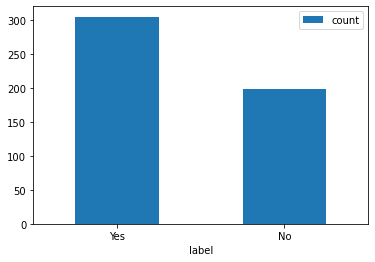

In [226]:
#english dataset stats
import seaborn as sns
import matplotlib.pyplot
lst = df['Has_Verifiable_Claim'].to_list()
print('Yes : ', lst.count('yes'), 'No : ', lst.count('no') )
df_plot = pd.DataFrame({'label':['Yes', 'No'], 'count':[lst.count('yes'), lst.count('no')]})
df_plot.plot.bar(x='label', y='count', rot=0)

Yes :  227 No :  153


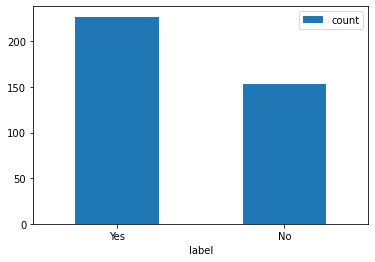

In [225]:
#bengali dataset stats
lst = df_bangla_mod['Has_Verifiable_Claim'].to_list()
print('Yes : ', lst.count('yes'), 'No : ', lst.count('no') )
df_plot = pd.DataFrame({'label':['Yes', 'No'], 'count':[lst.count('yes'), lst.count('no')]})
df_plot.plot.bar(x='label', y='count', rot=0)

Yes :  206 No :  143


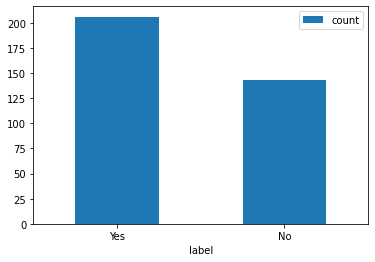

In [224]:
#hindi dataset stats
lst = df_hindi_mod['Has_Verifiable_Claim'].to_list()
print('Yes : ', lst.count('yes'), 'No : ', lst.count('no') )
df_plot = pd.DataFrame({'label':['Yes', 'No'], 'count':[lst.count('yes'), lst.count('no')]})
df_plot.plot.bar(x='label', y='count', rot=0)